In [1]:
import torch
import torch.nn as nn
import timm
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, precision_recall_fscore_support
from torchvision import datasets, transforms
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),          # Convert images to tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

In [3]:
# Load dataset
train_dataset = datasets.ImageFolder(root="/kaggle/input/e-waste/dataset/train", transform=transform)
val_dataset = datasets.ImageFolder(root="/kaggle/input/e-waste/dataset/val", transform=transform)
test_dataset = datasets.ImageFolder(root="/kaggle/input/e-waste/dataset/test", transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [4]:
# Get number of classes
num_classes = len(train_dataset.classes)
print(num_classes)
class_names = train_dataset.classes
print(class_names)

9
['Keyboard', 'Laptop', 'Miacrowave', 'Mobile', 'Mouse', 'Player', 'Printer', 'Refrigerator', 'Washing Machine']


In [5]:
# Training function with model checkpointing
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5):
    best_val_acc = 0.0  # Track best validation accuracy
    best_model_path = "best_vgg16_model.pth"

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        val_acc = evaluate_model(model, val_loader)

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

        # Save model if validation accuracy improves
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), best_model_path)
            print(f"New best model saved with val_acc: {val_acc:.4f}")

In [6]:
# Evaluation function
def evaluate_model(model, data_loader):
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(probs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")
    
    return correct / total

In [12]:
def evaluate_model_test(model, data_loader):
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)  # Convert logits to probabilities
            _, predicted = torch.max(probs, 1)  # Get class indices
            
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            
            all_preds.extend(probs.cpu().numpy())  # Store probability distributions
            all_labels.extend(labels.cpu().numpy())

    # Confusion Matrix
    cm = confusion_matrix(all_labels, np.argmax(all_preds, axis=1))  # Convert probs to class indices
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    # Classification Report
    print("Classification Report:")
    print(classification_report(all_labels, np.argmax(all_preds, axis=1), target_names=class_names))

    # AUC-ROC Curve
    if num_classes > 1:
        roc_score = roc_auc_score(all_labels, all_preds, multi_class='ovr')
        print(f"AUC-ROC Score: {roc_score:.4f}")

        # Plot ROC curve
        plt.figure(figsize=(4, 3))
        for i in range(num_classes):
            fpr, tpr, _ = roc_curve(np.array(all_labels) == i, np.array(all_preds)[:, i])
            plt.plot(fpr, tpr, label=f'Class {class_names[i]}')
        
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("AUC-ROC Curve")
        plt.legend()
        plt.show()

    return correct / total

In [59]:
# Load ViT model
model = timm.create_model("vit_base_patch16_224", pretrained=True, num_classes=num_classes)
model = model.to(device)

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [60]:
# Define loss and optimizer
criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5, weight_decay=5e-4)

In [61]:
# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=3) 

Precision: 0.9602, Recall: 0.9596, F1-score: 0.9595
Epoch 1/3, Loss: 0.1669, Train Acc: 0.9497, Val Acc: 0.9596
New best model saved with val_acc: 0.9596
Precision: 0.9548, Recall: 0.9514, F1-score: 0.9515
Epoch 2/3, Loss: 0.0349, Train Acc: 0.9897, Val Acc: 0.9514
Precision: 0.9462, Recall: 0.9440, F1-score: 0.9442
Epoch 3/3, Loss: 0.0269, Train Acc: 0.9914, Val Acc: 0.9440


In [62]:
# Test the model
test_acc = evaluate_model(model, test_loader)
print(f"Test Accuracy: {test_acc:.4f}")

Precision: 0.9688, Recall: 0.9679, F1-score: 0.9676
Test Accuracy: 0.9679


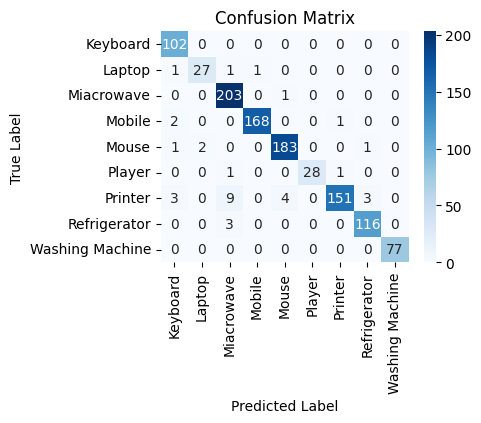

Classification Report:
                 precision    recall  f1-score   support

       Keyboard       0.94      1.00      0.97       102
         Laptop       0.93      0.90      0.92        30
     Miacrowave       0.94      1.00      0.96       204
         Mobile       0.99      0.98      0.99       171
          Mouse       0.97      0.98      0.98       187
         Player       1.00      0.93      0.97        30
        Printer       0.99      0.89      0.93       170
   Refrigerator       0.97      0.97      0.97       119
Washing Machine       1.00      1.00      1.00        77

       accuracy                           0.97      1090
      macro avg       0.97      0.96      0.96      1090
   weighted avg       0.97      0.97      0.97      1090

AUC-ROC Score: 0.9991


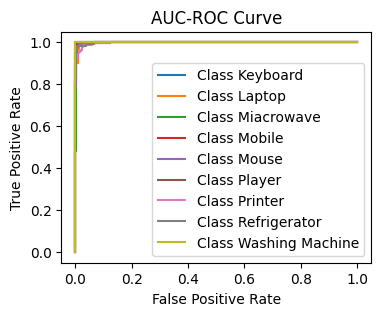

Test Accuracy: 0.9679


In [63]:
test_acc = evaluate_model_test(model, test_loader)
print(f"Test Accuracy: {test_acc:.4f}") 

### VGG 16

In [23]:
import torchvision.models as models

# Load VGG16 model
# model = models.vgg16(pretrained=True)
model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

# Modify classifier for the new number of classes
model.classifier[6] = nn.Linear(4096, num_classes)
model = model.to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5, weight_decay=5e-4)  #2e-5 se 5e-5

In [24]:
# Train the model                
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=3)

Precision: 0.8967, Recall: 0.8835, F1-score: 0.8843
Epoch 1/3, Loss: 0.4226, Train Acc: 0.8651, Val Acc: 0.8835
New best model saved with val_acc: 0.8835
Precision: 0.9083, Recall: 0.9073, F1-score: 0.9071
Epoch 2/3, Loss: 0.1553, Train Acc: 0.9524, Val Acc: 0.9073
New best model saved with val_acc: 0.9073
Precision: 0.8920, Recall: 0.8844, F1-score: 0.8835
Epoch 3/3, Loss: 0.0918, Train Acc: 0.9688, Val Acc: 0.8844


In [25]:
# Load the best model before evaluation
model.load_state_dict(torch.load("best_vgg16_model.pth"))
# print("Best model loaded for testing.")

<ipython-input-25-e93f29ea9839>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_vgg16_model.pth"))


Best model loaded for testing.


In [64]:
# Test the model
test_acc = evaluate_model(model, test_loader)
print(f"Test Accuracy: {test_acc:.4f}")

# Precision: 0.9516, Recall: 0.9505, F1-score: 0.9505
# Test Accuracy: 0.9505

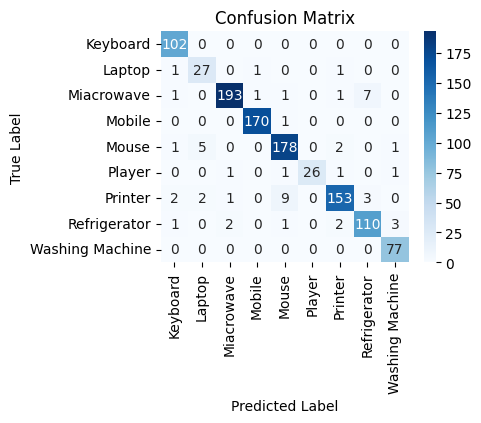

Classification Report:
                 precision    recall  f1-score   support

       Keyboard       0.94      1.00      0.97       102
         Laptop       0.79      0.90      0.84        30
     Miacrowave       0.98      0.95      0.96       204
         Mobile       0.99      0.99      0.99       171
          Mouse       0.93      0.95      0.94       187
         Player       1.00      0.87      0.93        30
        Printer       0.96      0.90      0.93       170
   Refrigerator       0.92      0.92      0.92       119
Washing Machine       0.94      1.00      0.97        77

       accuracy                           0.95      1090
      macro avg       0.94      0.94      0.94      1090
   weighted avg       0.95      0.95      0.95      1090

AUC-ROC Score: 0.9968


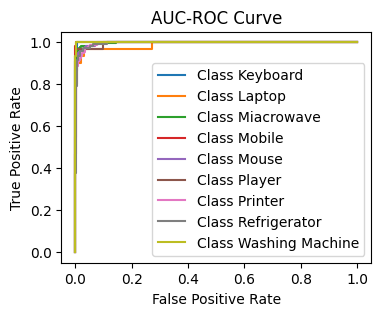

Test Accuracy: 0.9505


In [13]:
test_acc = evaluate_model_test(model, test_loader)
print(f"Test Accuracy: {test_acc:.4f}") 

## **RESNET50**

In [45]:
# Load ResNet-50 model
model = timm.create_model("resnet50", pretrained=True, num_classes=num_classes)
model = model.to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4, weight_decay=5e-4)

In [46]:
# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=3) 

Precision: 0.9130, Recall: 0.9101, F1-score: 0.9102
Epoch 1/3, Loss: 0.8293, Train Acc: 0.7686, Val Acc: 0.9101
New best model saved with val_acc: 0.9101
Precision: 0.9305, Recall: 0.9294, F1-score: 0.9295
Epoch 2/3, Loss: 0.2269, Train Acc: 0.9302, Val Acc: 0.9294
New best model saved with val_acc: 0.9294
Precision: 0.9221, Recall: 0.9202, F1-score: 0.9204
Epoch 3/3, Loss: 0.1390, Train Acc: 0.9580, Val Acc: 0.9202


In [47]:
# Load the best model before evaluation
model.load_state_dict(torch.load("best_vgg16_model.pth"))
# print("Best model loaded for testing.")

<ipython-input-47-8d2c3abb9134>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_vgg16_model.pth"))


<All keys matched successfully>

In [48]:
# Test the model
test_acc = evaluate_model(model, test_loader)
print(f"Test Accuracy: {test_acc:.4f}")

Precision: 0.9625, Recall: 0.9624, F1-score: 0.9622
Test Accuracy: 0.9624


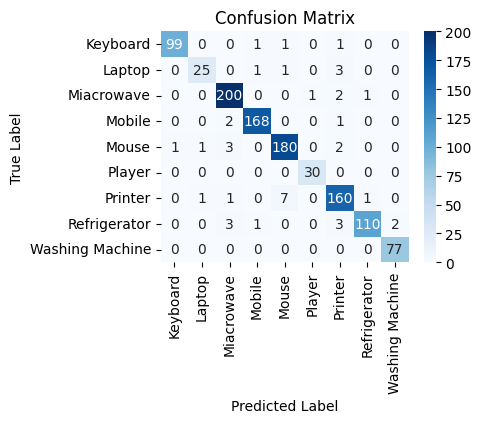

Classification Report:
                 precision    recall  f1-score   support

       Keyboard       0.99      0.97      0.98       102
         Laptop       0.93      0.83      0.88        30
     Miacrowave       0.96      0.98      0.97       204
         Mobile       0.98      0.98      0.98       171
          Mouse       0.95      0.96      0.96       187
         Player       0.97      1.00      0.98        30
        Printer       0.93      0.94      0.94       170
   Refrigerator       0.98      0.92      0.95       119
Washing Machine       0.97      1.00      0.99        77

       accuracy                           0.96      1090
      macro avg       0.96      0.95      0.96      1090
   weighted avg       0.96      0.96      0.96      1090

AUC-ROC Score: 0.9985


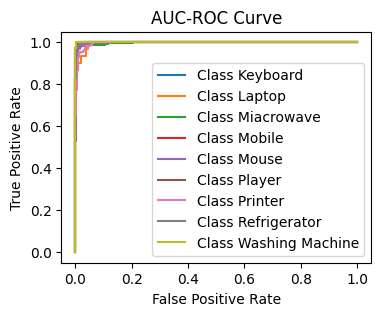

Test Accuracy: 0.9624


In [49]:
test_acc = evaluate_model_test(model, test_loader)  #85
print(f"Test Accuracy: {test_acc:.4f}") 

## XceptioNET

In [55]:
model = timm.create_model("xception", pretrained=True, num_classes=num_classes)
model = model.to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=6e-4, weight_decay=5e-4)

/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


In [56]:
# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=3)

Precision: 0.8544, Recall: 0.8312, F1-score: 0.8331
Epoch 1/3, Loss: 0.6236, Train Acc: 0.8112, Val Acc: 0.8312
New best model saved with val_acc: 0.8312
Precision: 0.8500, Recall: 0.8385, F1-score: 0.8386
Epoch 2/3, Loss: 0.4408, Train Acc: 0.8572, Val Acc: 0.8385
New best model saved with val_acc: 0.8385
Precision: 0.8752, Recall: 0.8661, F1-score: 0.8668
Epoch 3/3, Loss: 0.3888, Train Acc: 0.8778, Val Acc: 0.8661
New best model saved with val_acc: 0.8661


In [34]:
# Test the model
test_acc = evaluate_model(model, test_loader)
print(f"Test Accuracy: {test_acc:.4f}")  #2e-4

Precision: 0.9484, Recall: 0.9477, F1-score: 0.9473
Test Accuracy: 0.9477


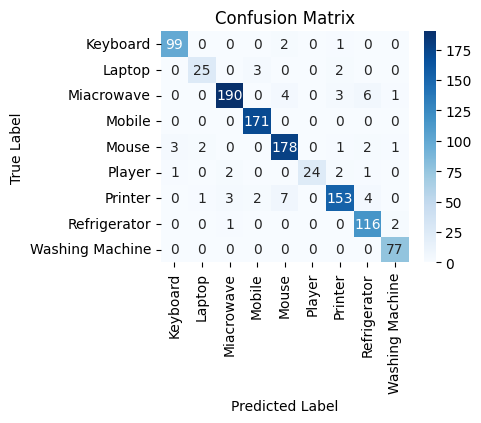

Classification Report:
                 precision    recall  f1-score   support

       Keyboard       0.96      0.97      0.97       102
         Laptop       0.89      0.83      0.86        30
     Miacrowave       0.97      0.93      0.95       204
         Mobile       0.97      1.00      0.99       171
          Mouse       0.93      0.95      0.94       187
         Player       1.00      0.80      0.89        30
        Printer       0.94      0.90      0.92       170
   Refrigerator       0.90      0.97      0.94       119
Washing Machine       0.95      1.00      0.97        77

       accuracy                           0.95      1090
      macro avg       0.95      0.93      0.94      1090
   weighted avg       0.95      0.95      0.95      1090

AUC-ROC Score: 0.9976


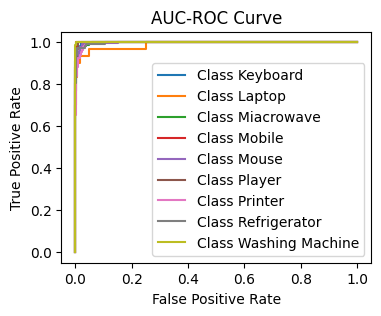

Test Accuracy: 0.9477


In [35]:
test_acc = evaluate_model_test(model, test_loader)
print(f"Test Accuracy: {test_acc:.4f}") 